# Please **DO NOT** run any cells as everything (all final images, graphs, etc. are preloaded)

# Section 0 Preface for Imports, Data Handling, & Methodologies 

## Section 0.1 Preface for Write-Up Interpretation & Acknowledgements

For the remainder of this notebook, each part 1) and 2) will be answered in line with notation for the following block of code to show:

1. A brief statement (~paragraph) of what was done to answer the question (narratively explaining what you did in code to answer the question, at a high level).

2. A brief statement (~paragraph) as to why this was done (why the question was answered in this way, not by doing something else. Some kind of rationale as to why you did x and not y or z to answer the question – why is what you did a suitable approach?).

For 3) and 4) (below) the findings and interpretations will be provided in Results & Discussions for each question (model(s)) we ran.

3. A brief statement (~paragraph) as to what was found. This should be as objective and specific as possible – just the results/facts. Do make sure to include numbers and a figure (=a graph or plot) in your statement, to substantiate and illustrate it, respectively. As the unsupervised methods often yield visualizable results, be sure to include a figure. 

4. A brief statement (~paragraph) as to what you think the findings mean. This is your interpretation of your findings and should answer the original question.

Code was used from my own Github repository, found at `www.github.com/sunnydigital/IDS_F21`, including code derived from Stephen Spivak from Introduction to Data Science, Fall 2021. Most of the code falling under the aforementioned two categories surrounds the `PCA` and `k-means` analysis plots.

All code used in this analysis attributable to Introduction to Machine Learning is not cited - we feel it is fair to use code from the course.

The author refers to all analysis performed in the first-person plural tense 'we,' as the author believes it to be weird to say *'I'* did anything, given all *I* did was learn from the amazing instructors & TAs :) Thank you.

## Section 0.2 Imports & Installation of Packages, Libraries, Seaborn Settings, and Dataset(s)

Below we set the random seed to the numeric portion of my NYU ID: `N12664675` import packages & libraries as well as set the settings for `seaborn` plots

In [62]:
!pip install xgboost
!pip install impyute
!pip install missingno
!pip install eli5
!pip install scikit-optimize
!pip install tune-sklearn ray[tune]
!pip install scikit-plot
!pip install colorcet==3.0.0
!pip install yellowbrick

zsh:1: no matches found: ray[tune]


Below we set the random seed to the numerical portion of our NYU ID (as per the spec sheet).

In [63]:
import random
random.seed(12664675)

In [64]:
import sys
import os
import time
import re

import numpy as np
import pandas as pd

from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

import scipy.stats as st
import statsmodels.api as sm ## Need revision for Windows use
from scipy.stats import zscore
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix, mean_squared_error as mse, f1_score
from sklearn import tree, ensemble, metrics, calibration
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostClassifier

from IPython import display

from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5

from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt import BayesSearchCV

'''from tune_sklearn import TuneSearchCV, TuneGridSearchCV
import ray.tune as tune'''

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import mlab
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import scikitplot as skplt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")
import graphviz
import colorcet as cc

from impyute.imputation.cs import fast_knn

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

from yellowbrick.classifier import ROCAUC

## Section 0.3 `NaN` Data Visual Inspection

Beow we view the potntially missing data out of the dataset we obtained. Missing data (yellow) are greatly contrasted with the present data (blue).

This was done to visually inspect the proportion of data missing versus those present.

<AxesSubplot:>

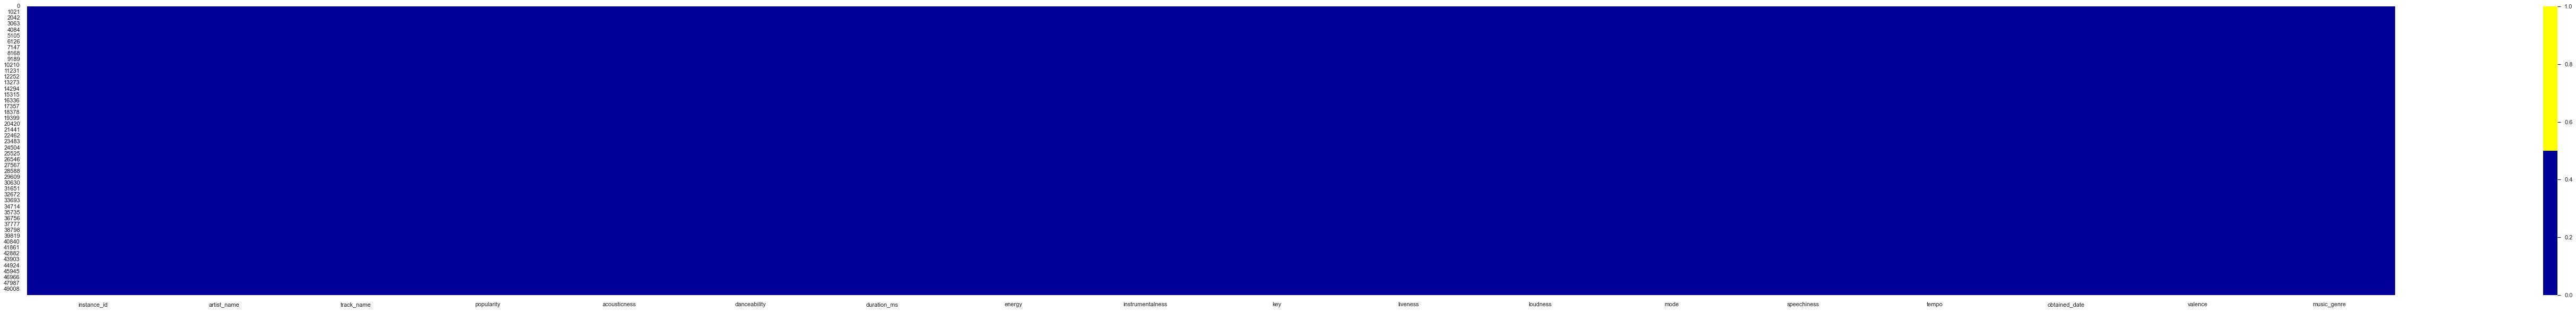

In [65]:
data = 'musicData.csv'
df = pd.read_csv(data)

colors = ['#000099', '#ffff00']
fig, ax = plt.subplots(figsize=(100,10))

sns.heatmap(df.isnull(), cmap=sns.color_palette(colors), ax=ax)

## Section 0.4 `string` Data Removal

Through our goal of classification/unsupervised learning, we will not include `string` data, as in the scope of this analysis, we will not be considering tthe potentially lingusitic properties of `artist_name`, `track_name`, `obtained_date`. Furthermore, `instance_id` is simply the unique classifier of an individual song, and given we are not considering the properties associated with a song, we will not need the specific label.

In [66]:
df_map = df[['instance_id', 'artist_name', 'track_name', 'obtained_date']]
df = df.loc[:, ~df.columns.isin(['instance_id', 'artist_name','track_name','obtained_date'])]

In [67]:
df.head(10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,0.323,Electronic
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.614,Electronic
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,0.230,Electronic
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,0.761,Electronic
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,0.273,Electronic
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,0.203,Electronic


## Section 0.5 Handling Null/String & Categorical Data

Below, we check the presence of `NA`'s and any non-numeric values in the dataframe and afterwards output a description of the dataframe.

First, we create a `lambda` function to attempt to `coerce` all columns into a `numeric` format, and if that is impossible, they are instead turned into `NaN`'s. Furthermore, incorrect (missing) values in the `duration_ms` column are represented as `-1` and also converted into `NaN`'s.

This was done to convert all potentially non-numeric values (entries that cannot be worked with) into a consolidated format.

Next, we impute using the `sklearn.impute.KNNImputer` to find missing values given other available labels in a sample. This incorporates all of the converted `NaN` values in the previous step.

This was done to numerically solve for missing values, using a k-Nearest Neighbor imputation technique, given the dearth of missing data (Section 0.3) that makes this technique particularly potent for the case.

In [68]:
lambda_apply = lambda x: pd.to_numeric(x, errors='coerce')
df[['popularity', 'acousticness', 'danceability', 'duration_ms', 
    'energy', 'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'tempo', 'valence']] = df[['popularity', 'acousticness', 'danceability', 'duration_ms', 
                                              'energy', 'instrumentalness', 'liveness', 'loudness',
                                              'speechiness', 'tempo', 'valence']].apply(lambda_apply).replace(-1, np.NaN)

In [69]:
to_impute = df[['popularity', 'acousticness', 'danceability', 'duration_ms', 
                'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']]

imputer = KNNImputer(n_neighbors=5)
impute_fit = imputer.fit_transform(to_impute)

df_drop = df.copy()

df_drop[['popularity', 'acousticness', 'danceability', 'duration_ms', 
         'energy', 'instrumentalness', 'liveness', 'loudness',
         'speechiness', 'tempo', 'valence']] = impute_fit

df_drop.dropna(inplace=True)

## Section 0.6 `key` & `mode` Column Combination

Below, we create a combined column out of `key` and `mode`, signifying the gradable key, mode (e.g. `A#_Major` or `C#_Minor`) combination in music, denoting the colloquial `key` a song is written in.

This was done in obervance of classical music theory and application of the Circle of Fifths[<sup>[1]</sup>](#fn1) showcasing the cyclical continuity of the `key` feature explored in this analysis.

In [70]:
df_drop['key'] = df_drop['key'] + '_' + df_drop['mode']
df_drop = df_drop.drop(labels=['mode'], axis='columns').reset_index(drop=True)

We then check the number of `NaN`' there are in a given column.


In [71]:
df_drop['tempo'].isnull().sum()

0

## Section 0.7 `LabelEncoder` Application to Obtain Numeric Feature Classes

In this section we use the `LabelEncoder` package from `sklearn.preprocessing` to obtain numerical data for features with string values that are continuous. We fit `key` (modified from the previous section) and the label classes in `music_genre` against `LabelEncoder`s.

This was done to enable the `PCA` and `XGBoost` algorithms to be applied later on the be usable.

In [72]:
key_le = LabelEncoder().fit(df_drop['key'])
key_encode = pd.DataFrame(data=key_le.transform(df_drop['key']), columns=['key'])

genre_le = LabelEncoder().fit(df_drop['music_genre'])
genre_encode = pd.DataFrame(data=genre_le.transform(df_drop['music_genre']), columns=['music_genre'])

key_inverse = lambda x: key_le.inverse_transform(x)
genre_inverse = lambda x: genre_le.inverse_transform(x)

In the following line we create a copy of `df_encode` and replace the original `key` & `music_genre` columns with the `LabelEncode` transformed outputs.

In [73]:
df_encode = df_drop.copy()

df_encode['key'] = key_encode['key']
df_encode['music_genre'] = genre_encode['music_genre']

We then inspect the entire dataframe to determine any missing (`NaN`) values. There fortunately seems to be none.

In [74]:
print(key_encode.isnull().sum())
print(genre_encode.isnull().sum())

df_encode.isnull().sum()

key    0
dtype: int64
music_genre    0
dtype: int64


popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

## Section 0.8 Train Test Split Using Stratification

In the section below we utilize `train_test_split` from `sklearn.model_selection` to obtain a test size `0.1` the size of the entire dataframe, and stratified against each class of the label (`y = df_encode['music_genre']`). This means we obtain proportional `0.1` amounts from each class label as opposed to obtaining from the total dataset, where it would be highly unlikely to obtain similar proportions of each class.

We do this in accordance to the Spec Sheet, but also to reduce sampling bias given the lack of equality in presence of all classes.

In [75]:
X = df_encode.loc[:,:'valence']
y = df_encode.loc[:,'music_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

## Section 0.9 Standardization & Normalization

For this dataset, (and the applicable functions of dimensionality reduction through PCA and clustering through k-means), I have chosen to standardize through the below mapping:

$$ \vec{X}_{\textrm{Z-Score}} = \frac{\vec{X} - \mu_{\vec{X}}}{\sigma_{\vec{X}}} $$

where each $\vec{X}$ is a given column of data.

In [76]:
X_train = st.zscore(X_train)
X_test = st.zscore(X_test)

# Section 1.0 PCA Fitting and Principal Component Analysis

We run a Principal Component Analysis using the `PCA` package from the `sklearn` library. When, we determine the `eig_vals` as the amount of explained variance, the `loadings` as the components of the output and `rotated_data` as the transformed data. Note the `* -1` for all lines of code: this was done due to a fundamental mistake in Python and makes outputs more interpretable. We then cycle through `eig_vals` to determine the percent of variance explained by each principal component.

This was done to initialize the PCA (with correct assumptions inclusive of Python flaws) and display the amount of variation attributable.

In [77]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

pca, pca_t = PCA().fit(X_train), PCA().fit(X_test)

eig_vals, eig_vals_t = pca.explained_variance_, pca_t.explained_variance_
loadings, loadings_t = pca.components_ * -1, pca_t.components_ * -1
rotated_data, rotated_data_t = pca.fit_transform(X_train) * -1, pca_t.fit_transform(X_test) * -1

covar_explained, covar_explained_t = eig_vals / sum(eig_vals) * 100, eig_vals_t / sum(eig_vals_t) * 100

for n in range(len(covar_explained)):
    explained = covar_explained[n].round(5)
    print(f'{ordinal(n+1)} PC explains {explained}% of variance')

1st PC explains 31.04849% of variance
2nd PC explains 11.28439% of variance
3rd PC explains 8.84077% of variance
4th PC explains 8.32752% of variance
5th PC explains 8.04052% of variance
6th PC explains 7.78231% of variance
7th PC explains 6.787% of variance
8th PC explains 6.03472% of variance
9th PC explains 4.94202% of variance
10th PC explains 3.85229% of variance
11th PC explains 2.14013% of variance
12th PC explains 0.91984% of variance


## Section 1.1 Scree Plot

Below we show a scree plot of the eigenvalues and the amount of total explainability (out of the total number of `eig_vals`) attributed to each PC. We then draw a line at `Eigenvalue = 1` to show how many `eig_vals` are above 1.

This was done to visually inspect the scree plot and determine the cutoff point for the Kaiser criterion (`Eigenvalue = 1`).

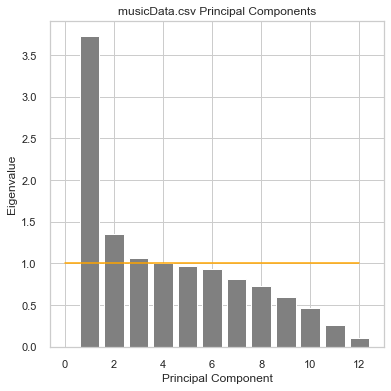

In [79]:
num_col = len(X_train.columns)
x = np.linspace(1,num_col, num_col)
plt.bar(x, eig_vals, color='gray')
plt.plot([0,num_col], [1,1], color='orange')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('musicData.csv Principal Components')
plt.show()

## Section 1.2 Kaiser, Elbow, 90% Variance

Below we show code regarding the number of PCs to choose around each criterion. 

  * For the Kaiser criterion, we count the number of PCs with `eigenvalue > 1`. This was determined to be3 PCs.
  * For the Elbow criterion I eyeballed the data and determined the cutoff point at 2 PCs
  * For the number of factors to account for more than 90% variance of the data, we ran `np.cumsum` on the `covar_explained` (as defined in Section 1.0) and count the number needed. This was determined to be 9 PCs

We do so due to these being the main methods of determining the number of PCs to choose, and run three methods to exhaustively optimize for the number.

Code from Introduction to Data Science, Fall 2021

In [80]:
threshold = 1

print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals > threshold))

print('Number of factors selected by Elbow criterion: 2')

threshold = 90
eig_sum = np.cumsum(covar_explained)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum < threshold) + 1)

Number of factors selected by Kaiser criterion: 3
Number of factors selected by Elbow criterion: 2
Number of factors to account for at least 90% variance: 9


## Section 1.3 Principal Component Loadings Plots

Below (two cells) we cycle through the first 9 PCs and plot each attributable loadings using `seaborn`. Next, we output each predictor and the associated label.

This was done to provide an initial visual inspection of the loadings plots of each PC.

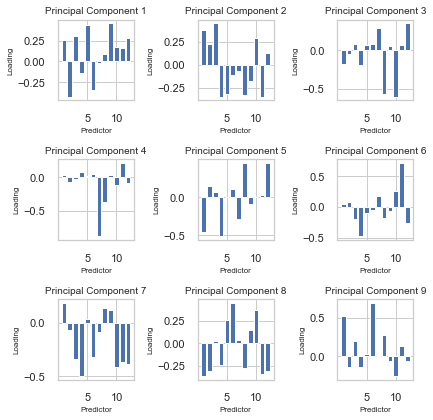

In [81]:
look_at = 9
for i in range(0,look_at):
    
    plt.subplot(3,3,i+1)
    plt.bar(x, loadings[i,:])
    
    plt.title(f'Principal Component {i+1}', fontsize=10)
    plt.xlabel('Predictor', fontsize=8)
    plt.ylabel('Loading', fontsize=8)
    
    plt.tight_layout()

In [82]:
for index in range(len(X_train.columns)):
    print(f'Predictor {index+1}: {X_train.columns[index]}')

Predictor 1: popularity
Predictor 2: acousticness
Predictor 3: danceability
Predictor 4: duration_ms
Predictor 5: energy
Predictor 6: instrumentalness
Predictor 7: key
Predictor 8: liveness
Predictor 9: loudness
Predictor 10: speechiness
Predictor 11: tempo
Predictor 12: valence


## Section 1.4 Scatterplot

We scatter a 2d plot of the first 2 PCs against each other, with PC1 on the x-axis and PC2 on the y-axis. We then color the scattered points associated with the appropriate label class.

This provides an ultimate visual representation of the associated PC loadings for later visual/clustering analysis, as well as a visual (colored) representation of the label calss each point belongs in.

Code modified from Introduction to Data Science Fall 2021

Text(0, 0.5, 'Principal Component 2')

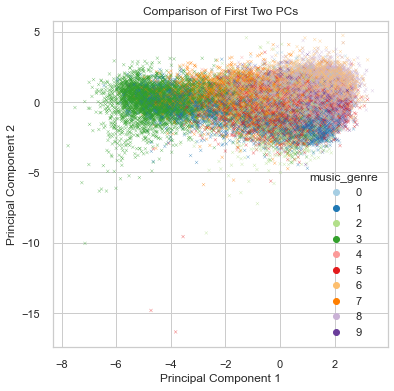

In [83]:
sns.scatterplot(x=rotated_data[:,0], y=rotated_data[:,1], hue=y_train, s=10, marker='x', palette='Paired')

plt.title('Comparison of First Two PCs')
# Set x-axis label
plt.xlabel('Principal Component 1')
# Set y-axis label
plt.ylabel('Principal Component 2')

## Section 1.5 3-D Plot of First 3 Principal Components.

We plot in 3d projections using `seaborn`'s `Axes3D` package the first 3 PCs. 

This was done to obtain a better understanding of the data. We see that PC3 does not seem to provide added variance, but rather a distribution horizontally around equal above and below the mean. However, in the 3rd dimension striations seem to result from the label classes presented.

/var/folders/75/nxb38mxd16q4m2ylbprp28s00000gn/T/ipykernel_78524/1430082577.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


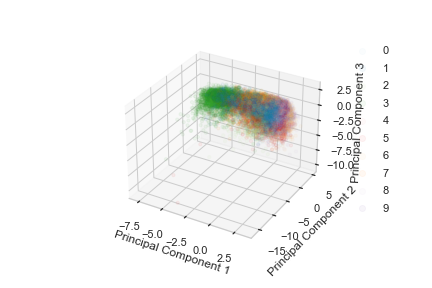

In [104]:
%matplotlib widget

fig = plt.figure()
ax = fig.gca(projection='3d')
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette('Paired', 10).as_hex())

sc = ax.scatter(rotated_data[:,0],
                rotated_data[:,1],
                rotated_data[:,2],
                s=40, marker='.', c=y_train.to_list(), cmap=cmap, alpha=0.05)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [105]:
%matplotlib inline

## Section 1.6 Results & Discussion

From the Section 1.1 scree plot & 1.3 analytical determination, we see that 4 PCs have `eigenvalue > 1`(adhering to the Kaiser criterion). This means that the number of PCs that have greater explanability of the total dataset greater than an individual feature is 3.

From the Section 1.0 original fitting and `cumsum` of `eig_vals` analysis, we see that the first PC accounts for "`31.04386%` of variance" and the second PC accounts for "`11.29876%` of variance" (the third PC accounting for `8.84217%`). Together, they (the first two) account for `42.34262%` of the variance in the data (with 3 PCs accounting for `51.18479%`). This means that with just 2 PCs, almost **half** of the variance in the data is accounted for (and with 3 PCs, slightly more than half is accounted for). In 2-D this would be a well-suited method for visual/future-clustering analysis, but in scope of this analysis (applying the Kaiser)

From viewing the `loadings` of the first two PCs, we see that:

   * PC1: loadings points very positively towards `popularity`, `danceability`, `energy`, `loudness`, and `valence` but very negatively towards `acousticness` and `instrumentalness`. Unlisted loadings were smaller/near-zero in magnitude.
   
   
   * PC2: strongly positive towards `popularity`, `acousticness`, `danceability`, `speechiness`, negatively towards `duration_ms`, `energy`, `liveliness`, `loudness`, and `tempo`. Unlisted loadings were smaller/near-zero in magnitude.
   
   
In interpretation, we see that PC1 is accute towards features able to be interpreted as having qualities of a "pop song" (with `popularity`, `danceability`, and `loudness` all influencing the quality), and PC2 as being accute in features positioned toward dance music: `danceability`, `popularity`, and `speechiness`.

# Section 2.0 K-Means Clustering

For this Section, we realized the importance of using a distance-preserving method of dimensionality reduction, given k-means' dependance on distance metrics to create clusters. This is why I chose PCA as the form of dimensionality reduction to be used, as opposed to t-SNE, which only preserves *local* similarities. I did not choose MDS nor t-SNE due to the lack of open interpretability of factors in both (loadings).

In the two blocks of code below, we call and create a `np.array` of the first two PCs of the PCA analysis done in Section 1. We then create a `np.array` of `NaN`s of `num_clusters` to look at, with `num_clusters=9` to store each sum of silhouette scores for every number of clusters tried.

We then loop through the 9 total clusters, using the `KMeans` class from `sklearn.cluster` to calculate the clusters for each number of clusters, and create subplots using `matplotlib` of associated silhouette score (found using `silhouette_samples` from `sklearn.metrics`) vs. count of occurrence. Each plot displays the number of clusters and the sum of the silhouette scores as the title.

This was done to output subplots showing the silhouette score vs. the count of occurrence, with titles bearing the sum of silhouette scores.

The code below is modified from Introduction to Data Science, Fall 2021

In [89]:
x = np.column_stack((rotated_data[:,0], rotated_data[:,1]))

num_clusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([num_clusters,1])*np.NaN # init container to store sums

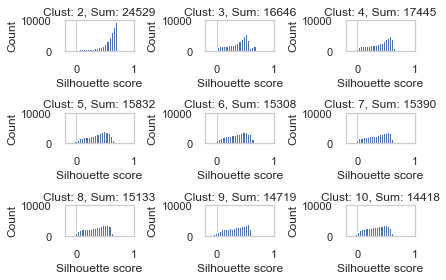

In [90]:
# Compute kMeans:
for i in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(i)).fit(x) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(x, cId) # compute the mean silhouette coefficient of all samples
    Q[i-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3, 3, i-1)
    plt.hist(s,bins=20) 
    plt.xlim(-0. 2,1)
    plt.ylim(0, 10000)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title(f'Clust: {i}, Sum: {int(Q[i-2])}') # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

## Section 2.1 Plot of Number of Clusters vs. Sum of Silhouette

Below we show on the x-axis the number of clusters vs. the sum of silhouette scores on the y-axis. We use `matplotlib` to plot the associated `np.linspace` object, set between 2 to 10 with 9 in-between divisions against the sum of silhouette scores obtained from the filled `Q` array in the previous section.

The code below is modified from Introduction to Data Science, Fall 2021

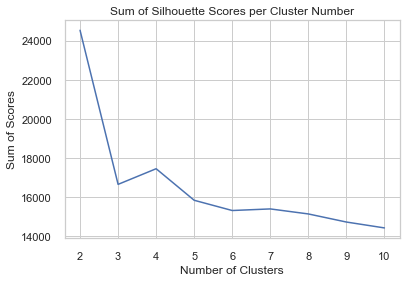

In [103]:
plt.plot(np.linspace(2,10,9), Q)

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Scores')
plt.title('Sum of Silhouette Scores per Cluster Number')

plt.show()

## Section 2.2 Plot of First Two PCs

Below we plot the the first two PCs, colored by individual clusters (the number of clusters obtained by optimal silhouette value obtained above through `np.argmax` of the `Q` silhouette sum array added to 2 (`np.argmax(Q) + 2` because we start at index 0 to store the lowest number of clusters, 2). We first hard code the optimal number of clusters into `num_clusters`, obtained from the silhouette plot (Section 2.1) above (which is `2`). We instance a `KMeans` class object and fit it with *two* dimensions of the `loadings` from PCA analysis (Section 1), as requested by the spec sheet to produce visualizations in 2-D. Next, looping through the number of clusters to be plotted (`num_clusters`), we plot (in `green`, `blue`, `orange` respectively), associated clusters by determining the indices of associated labels in `rotated_data`. Finally, we plot the associated centroids.

This was done to visualize in two PC dimensions individual clusters, alongside their associated centroids.

*Note*: if code does not output clusters ALONGSIDE centroids, please disregard this section in grading and use the 3-D analogy of Section 2.3 instead.

Code adapted from Introduction to Data Science, Fall 2021

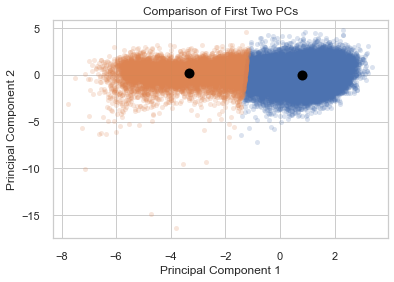

In [96]:
%matplotlib inline
num_clusters = np.argmax(Q) + 2
kMeans = KMeans(n_clusters=num_clusters)
kMeans = kMeans.fit(np.column_stack((rotated_data[:,0], rotated_data[:,1])))

cId = kMeans.labels_
cCoords = kMeans.cluster_centers_

for i in range(num_clusters):
    plotIndex = np.argwhere(cId == int(i))
    plt.plot(rotated_data[plotIndex,0], rotated_data[plotIndex,1], '.', markersize=10, alpha=0.2)
    plt.plot(cCoords[i,0], cCoords[i,1],'o', markersize=10, color='black', alpha=1.0)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Comparison of First Two PCs')

## Section 2.3 3-D Plot of 3 Principal Component Clustering

This section maps the two chosen optimal number of clusters onto a 3-D space with 3 PCs. 

This was done to visualize what k-means would look like in higher-dimensions with more variation in the data (explained by more PCs) included.

Text(0.5, 0, 'Principal Component 3')

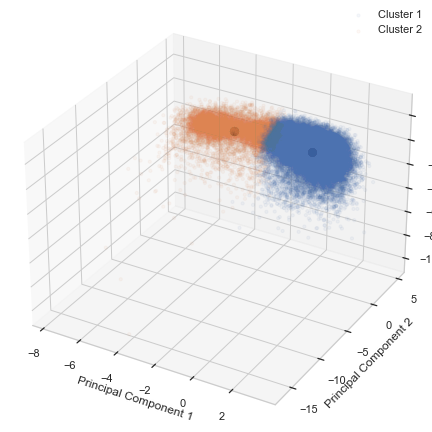

In [100]:
%matplotlib notebook

num_clusters = np.argmax(Q) + 2
kMeans = KMeans(n_clusters = num_clusters).fit(np.column_stack((rotated_data[:,0],
                                                                rotated_data[:,1],
                                                                rotated_data[:,2]))) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Plot the color-coded data:
for i in range(num_clusters):
    
    plotIndex = np.argwhere(cId == int(i))
    
    sc = ax.scatter(rotated_data[plotIndex,0],
                    rotated_data[plotIndex,1],
                    rotated_data[plotIndex,2],
                    label=f'Cluster {i+1}',
                    s=40, marker='.', alpha=0.05)
    
    sc = ax.scatter(cCoords[int(i-1),0],
                    cCoords[int(i-1),1],
                    cCoords[int(i-1),2],
                    color='black', s=70, alpha=1.0)
    
ax.legend(loc='best')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

In [106]:
%matplotlib inline

## Section 2.4 Results & Discussion

From the above, we find that by implementing k-means on a PCA reduced `musicData.csv`, with a sum of silhouette scores of `24558`, and an optimal number of clusters of `2` (Sections 2.0 & 2.1), we obtain the visualization shown in Section 2.2.

This however, could *potentially* not be accurate given a brief viewing of the dataset: shown in Section 2.1, we can see isses with the dataset being potentially unable to be broken up into individual "spherical clusters" (due to the singular, already clustered blob resulting from the PCA). Potential outliers are also included in the k-means analysis, such as the point around (`-3.9`, `-15.25`) in the graph of Section 2.2.

However, this could also mean that using the first *two* and *three* PCs respectively, explaining `42.34262%` and `51.18479%` of the variation in the data respectively (Section 1.6), `2` clusters *do* exist, allowing for further analysis through unsupervised classification (not proceeded with in the scope of this analysis).

# Section 3.0 Xtreme Gradient Boost (`XGBoost`) Function Definitions

Below we create a dictionary of preprocessed `training_data` inclusive of `X_train`, `X_test`, `y_train`, & `y_test`.

This was done for ease of accessibility.

In the next block of code, we define `fitXgb` to output the fitting progress (`mlogloss` and `merror`, `m` meaning multiclass for each `test` and `train` sets) every 100 epochs. At the end of fitting, we output the `accuracy`, `micro f1` score, and `macro f1` score.[<sup>[4]</sup>](#fn4)

Each `micro` and `macro` score utilize different aggregation methods of determining a combined score, with `micro` calculating each precision, recall by aggregating then dividing, and `macro` calculating each precision and recall individually, then finding the combined average.

We then define `plot_compare` to output visualization plots of the `mlogloss` and `merror` for each `train` and `test` set.

This was done to give more quantitative (for the former) and qualitative (latter plot) information regarding the fitting of the `XGBoost` model.

I choose `XGBoost` due to it being the "silver bullet" of Machine Learning at the moment, as well as the combinatorially positive effects of mixing together the plus-sides of random forests (bagging) as well as the adherence to an objective (loss) function through "Gradient Boosting." Gradient Boosted Decision Trees (GBDTs) formalizes additively generating weak models (akin to AdaBoost) but over an objective function. Each successive, iterative model trains a "shallow decision tree,.. over the error residuals of a previous model to fit the next." The model then weighs the sum of all predictions.[<sup>[5]</sup>](#fn5)

In [107]:
training_data = {'X_train': rotated_data[:,:4],
                 'X_test': rotated_data_t[:,:4],
                 'y_train': y_train,
                 'y_test': y_test}

In [108]:
#allow logloss and classification error plots for each iteration of xgb model
def plot_compare(metrics, eval_results, epochs):
    for m in metrics:
        test_score = eval_results['test'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Test")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data, epochs=100):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['y_train'].values.reshape(-1, 1))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(test, 'test'), (train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=store, verbose_eval=100)
    print('-- Model Report --')
    
    accuracy = accuracy_score(sk_model.predict(training_data['X_test']), training_data['y_test'])
    f1_micro = f1_score(sk_model.predict(training_data['X_test']), training_data['y_test'], average='micro')
    f1_macro = f1_score(sk_model.predict(training_data['X_test']), training_data['y_test'], average='macro')
    
    print(f'XGBoost Accuracy: {accuracy}')
    print(f'XGBoost F1-Score (Micro): {f1_micro}')
    print(f'XGBoost F1-Score (Macro): {f1_macro}')

    plot_compare(metrics, store, epochs)

## Section 3.1 `XGBoost` Initial Fitting & Analysis

Below, we fit out initial `XGBoost` model, `xgb_clf1` with `objective=softproba` to determine AUC ROC in later sections.

This was done to be able to determine AUC ROC (also, as specified by the spec sheet). We specify which hyperparameters will be tuned later on within the code, and output graphics and text using the functions defined in Section 3.0 above.

In [109]:
## Computer/dataset specifics about running the XGBoost model
num_threads = 8
num_classes = 10

In [110]:
#initial model
xgb_clf1 = XGBClassifier(learning_rate=0.1,
                         n_estimators=1000,
                         max_depth=5, #tunable
                         min_child_weight=1, #tunable
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='multi:softproba',
                         nthread=num_threads,
                         num_class=num_classes,
                         seed=1234567)

Fitting model...
Fitting done!
[0]	test-mlogloss:2.24280	test-merror:0.71080	train-mlogloss:2.23709	train-merror:0.68424


/Users/sunnyson/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[99]	test-mlogloss:1.72184	test-merror:0.67020	train-mlogloss:1.52533	train-merror:0.58136
-- Model Report --
XGBoost Accuracy: 0.3096
XGBoost F1-Score (Micro): 0.3096
XGBoost F1-Score (Macro): 0.29959849702613905


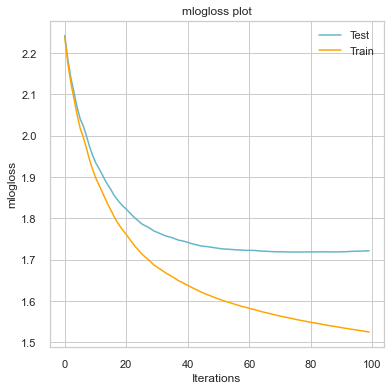

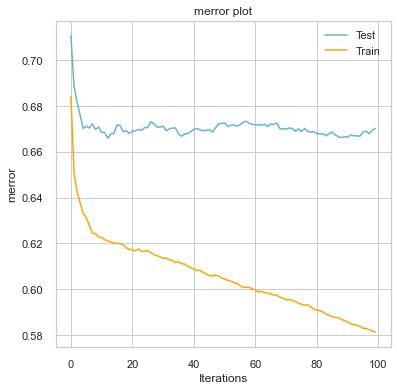

In [111]:
fitXgb(xgb_clf1, training_data)

## Section 3.2 Tuning `max_depth` & `min_child_weight`

Direcly below, we define `getTrainScores` to output more detail about the fully tuned model shown further below.

Two blocks below, we create a `param_test` dictionary of hyperparameters to tune, the two being `max_depth` & `min_child_weight`. We then use `GridSearchCV` from `sklearn.model_selection` to fit different cardinal products of the `param_test` hyperparameters to maximize the `ovr_auc_roc` function. 

The aforementioned loss function is a heuristic for using individual, binary classifications to proxy a multi-class classification on the AUC ROC of the target class versus the combination of all other classes for the label.

This was done to induce hyperparameter tuning of the two mentioned above, but in a way directed towards maximizing AUC ROC. 

In [112]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [113]:
param_test1 = {
 'max_depth': [3, 6, 9],
 'min_child_weight': [1, 3, 5]
}
# metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator=xgb_clf1, param_grid=param_test1, scoring='roc_auc_ovr', verbose=10, cv=2)
gsearch1.fit(training_data['X_train'], training_data['y_train'])

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2; 1/9] START max_depth=3, min_child_weight=1.............................
[CV 1/2; 1/9] END max_depth=3, min_child_weight=1;, score=0.815 total time= 1.0min
[CV 2/2; 1/9] START max_depth=3, min_child_weight=1.............................
[CV 2/2; 1/9] END max_depth=3, min_child_weight=1;, score=0.816 total time= 1.2min
[CV 1/2; 2/9] START max_depth=3, min_child_weight=3.............................
[CV 1/2; 2/9] END max_depth=3, min_child_weight=3;, score=0.815 total time= 1.1min
[CV 2/2; 2/9] START max_depth=3, min_child_weight=3.............................
[CV 2/2; 2/9] END max_depth=3, min_child_weight=3;, score=0.816 total time=  57.7s
[CV 1/2; 3/9] START max_depth=3, min_child_weight=5.............................
[CV 1/2; 3/9] END max_depth=3, min_child_weight=5;, score=0.815 total time=  51.7s
[CV 2/2; 3/9] START max_depth=3, min_child_weight=5.............................
[CV 2/2; 3/9] END max_depth=3, min_chil

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
           

In [114]:
getTrainScores(gsearch1)

({0: "mean:0.8156157459533608params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.8152964554183812params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.8153314858710563params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.8009061569272977params{'max_depth': 6, 'min_child_weight': 1}",
  4: "mean:0.799073213717421params{'max_depth': 6, 'min_child_weight': 3}",
  5: "mean:0.7985815017832647params{'max_depth': 6, 'min_child_weight': 5}",
  6: "mean:0.7903423593964335params{'max_depth': 9, 'min_child_weight': 1}",
  7: "mean:0.7885236373113854params{'max_depth': 9, 'min_child_weight': 3}",
  8: "mean:0.7873373580246914params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.8156157459533608,
  'best_param': {'max_depth': 3, 'min_child_weight': 1}})

### Section 3.2.1 Optimal Parameter Selection

Below we select the optimal parameters for `opt_min_child` and ` opt_max_depth` based on hyperparameter tuning done previously.

In [115]:
opt_min_child = 1
opt_max_depth = 3

### Section 3.2.2 Output of Model with Optimal `max_depth` & `min_child_weight`

Below we output the model with the determined optimal `max_depth` and `min_child_height` found above. We evoke the functions defined in Section 3.0 to visually and numerically break down `mlogloss` and `merror`.

Fitting model...
Fitting done!
[0]	test-mlogloss:2.24656	test-merror:0.71280	train-mlogloss:2.24377	train-merror:0.69944


/Users/sunnyson/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[99]	test-mlogloss:1.71226	test-merror:0.67100	train-mlogloss:1.61737	train-merror:0.62084
-- Model Report --
XGBoost Accuracy: 0.3162
XGBoost F1-Score (Micro): 0.3162
XGBoost F1-Score (Macro): 0.3060725450187838


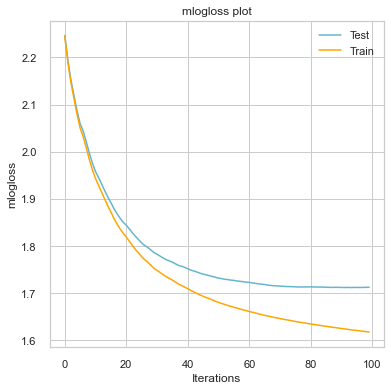

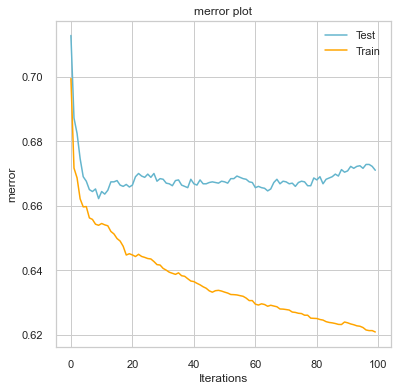

In [116]:
xgb_clf2 = XGBClassifier(learning_rate=0.1,
                         n_estimators=1000,
                         max_depth=opt_max_depth, # tuned
                         min_child_weight=opt_min_child, # tuned
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='multi:softproba',
                         nthread=num_threads,
                         num_class=num_classes,
                         seed=1234567)

fitXgb(xgb_clf2, training_data)

## Section 3.3 Tuning `reg_alpha`

Direcly below, we define `getTrainScores` to output more detail about the fully tuned model shown further below.

Two blocks below, we create a `param_test` dictionary of hyperparameters to tune, the two being `reg_alpha`. We then use `GridSearchCV` from `sklearn.model_selection` to fit different cardinal products of the `param_test` hyperparameters to maximize the `ovr_auc_roc` function.

The aforementioned loss function is a heuristic for using individual, binary classifications to proxy a multi-class classification on the AUC ROC of the target class versus the combination of all other classes for the label.

This was done to induce hyperparameter tuning of the two mentioned above, but in a way directed towards maximizing AUC ROC. 

In [117]:
param_test2 = {
 'reg_alpha':[1e-2, 0.1, 1]
}

gsearch2 = GridSearchCV(estimator = xgb_clf2, param_grid = param_test2, scoring='roc_auc_ovr', verbose = 10, cv=2)
gsearch2.fit(training_data['X_train'], training_data['y_train'])

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START reg_alpha=0.01..............................................
[CV 1/2; 1/3] END ...............reg_alpha=0.01;, score=0.815 total time=  35.1s
[CV 2/2; 1/3] START reg_alpha=0.01..............................................
[CV 2/2; 1/3] END ...............reg_alpha=0.01;, score=0.816 total time=  42.9s
[CV 1/2; 2/3] START reg_alpha=0.1...............................................
[CV 1/2; 2/3] END ................reg_alpha=0.1;, score=0.815 total time=  37.3s
[CV 2/2; 2/3] START reg_alpha=0.1...............................................
[CV 2/2; 2/3] END ................reg_alpha=0.1;, score=0.816 total time=  34.3s
[CV 1/2; 3/3] START reg_alpha=1.................................................
[CV 1/2; 3/3] END ..................reg_alpha=1;, score=0.815 total time=  45.6s
[CV 2/2; 3/3] START reg_alpha=1.................................................
[CV 2/2; 3/3] END ..................reg_alpha=1;, 

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=1,
           

In [118]:
getTrainScores(gsearch2)

({0: "mean:0.8156626792866941params{'reg_alpha': 0.01}",
  1: "mean:0.8156025240054869params{'reg_alpha': 0.1}",
  2: "mean:0.8154581849108367params{'reg_alpha': 1}"},
 {'best_mean': 0.8156626792866941, 'best_param': {'reg_alpha': 0.01}})

In [119]:
opt_reg_alpha = 0.01

## Section 3.3.1 Final Model Output & Loss Visualization (w/ Optimized `max_depth`, `min_child_weight`, & `reg_alpha`)

Below we output the model with the determined optimal `max_depth`, `min_child_height`, and `reg_alpha` found above. We evoke the functions defined in Section 3.0 to visually and numerically break down `mlogloss` and `merror`.

Fitting model...
Fitting done!
[0]	test-mlogloss:2.24656	test-merror:0.71280	train-mlogloss:2.24377	train-merror:0.69944


/Users/sunnyson/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[99]	test-mlogloss:1.71240	test-merror:0.67180	train-mlogloss:1.61757	train-merror:0.62124
-- Model Report --
XGBoost Accuracy: 0.3142
XGBoost F1-Score (Micro): 0.3142
XGBoost F1-Score (Macro): 0.3034744675861638


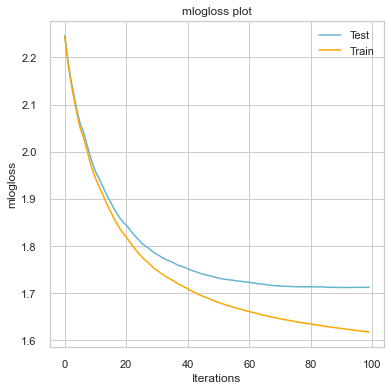

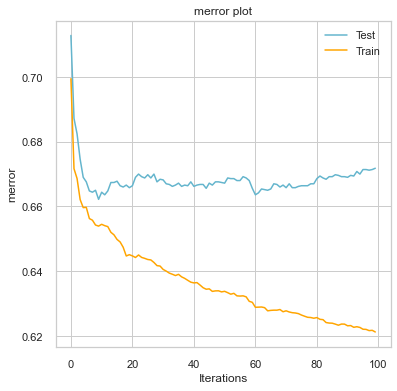

In [120]:
xgb_clf3 = XGBClassifier(learning_rate=0.1,
                         n_estimators=1000,
                         max_depth=opt_max_depth, # tuned (previously)
                         min_child_weight=opt_min_child, # tuned (previously)
                         reg_alpha=opt_reg_alpha, # tuned
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='multi:softproba',
                         nthread=10,
                         num_class=10,
                         seed=1234567)

fitXgb(xgb_clf3, training_data)

## Section 3.4 Results & Discussion

From the above, we can see that an `XGBoost` model initiated with the hyperparameters `max_depth=3`, `min_child_weight=1`, `reg_alpha=0.01` makes for the lowest `mlogloss=1.66697` and `merror=0.65900` with a `micro f1=0.345`, a `macro f1=0.33689`, and `accuracy=0.345`.

We can interpret this as meaning `XGBoost` as not having a too-distinctive ability to differentiate `music_genre` based on the first 3 Principal Components of the `musicData.csv` dataset. For a real-world dataset, achieveing `~0.25` is impressive enough, so the model is not without merit. However, further results (such as the AUC ROC plot showin the section below) will moreso elucidate predictive ability versus guessing. 

# Section 4.0 AUC ROC of Fitted & Tuned `XGBoost` Model

Below we define a function `plot_ROC_curve` that takes in the parameters `model`, `xtrain`, `ytrain`, `xtest`, and `ytest` to output the AUC ROC of each multiclass (multiple classes but each sample can only belong to one class) entry. Furthermore, different aggregations (`micro` and `macro` averages) of the AUC ROC curve of the model as a whole are presented.

This was done as per the spec sheet, to visually output not only the AUC ROC curve of every class, but also the AUC ROC performance of the model as a whole through different consolidation methods (`micro` and `macro`).

In [121]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Alternative', 
                                        1: 'Anime', 
                                        2: 'Blues',
                                        3: 'Classical',
                                        4: 'Country',
                                        5: 'Electronic',
                                        6: 'Hip-Hop',
                                        7: 'Jazz',
                                        8: 'Rap',
                                        9: 'Rock'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

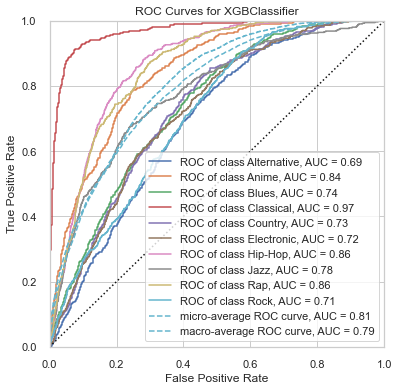

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Alternative', 1: 'Anime', 2: 'Blues', 3: 'Classical',
                4: 'Country', 5: 'Electronic', 6: 'Hip-Hop', 7: 'Jazz',
                8: 'Rap', 9: 'Rock'},
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_by...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
              

In [122]:
clf_choice = xgb_clf3
plot_ROC_curve(clf_choice, training_data['X_train'], y_train, training_data['X_test'], y_test)

# Section 4.1 Results & Discussion

From the above analysis, we see that even given the low `accuracy` and `f1` metrics, we obtain above-random performance for the AUC ROC.

With a range of `min=(Alternative=0.71)` to `max=(Classical=0.96)`, the scores of individual features `ovr` (one versus rest comparison mentioned earlier) are displayed.

Also shown are the `micro=0.83` and `macro=0.81` averages of the AUC ROC curve of the entire model as a whole.

I interpret these numbers for the AUC ROC as showing that our model best classifies `Classical` music, and worstly does so for `Alternative`.

The `micro` and `macro` aggregations individually and combined show the efficacy of this model to perform better than random guessing.

From this, I think the most important factor of classification in this dataset is the availability of predictors that are able to better differentiate music (such as popularity).

# Section 5.0 Works Cited

[1] <span id='fn1'> https://ledgernote.com/columns/music-theory/circle-of-fifths-explained/ </span>

[2] <span id='fn2'> https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368 </span>

[3] <span id='fn3'> https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de </span>

[4] <span id='fn4'> https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin </span>

[5] <span id='fn5'> https://www.nvidia.com/en-us/glossary/data-science/xgboost/ </span>

# Section 6.0 Appendix

## Section 6.1 Depreciated Code

In [ ]:
df_drop = df.drop(index=df[(df['duration_ms'] == -1)].index, axis=0).reset_index(drop=True)

In [ ]:
string_data = ['key']
categorical_data = ['mode', 'music_genre']

smap = lambda x: re.search('\w+(?!_)', x)[0]
cmap = lambda x: re.search('\w+(?=_name)|mode|((?<=music_)\w+)', x)[0]

In [ ]:
encode_string = {}
for i, col in zip(range(len(string_data)), string_data):
    encode_string[f'encode_{smap(col)}'] = LabelEncoder().fit(df[[col]])
    
encode_categorical = {}
for i, col in zip(range(len(categorical_data)), categorical_data):
    encode_string[f'encode_{cmap(col)}'] = LabelEncoder().fit(df[[col]])

In [ ]:
df_process = pd.get_dummies(data=df_encode, prefix='mode', columns=['mode'])

df_process = df_process[['popularity', 'acousticness', 'danceability', 'duration_ms', 
                         'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode_Major', 'mode_Minor', 
                         'speechiness', 'tempo', 'valence', 'music_genre']]

df_process[['tempo', 'mode_Major', 'mode_Minor']] = df_process[['tempo', 'mode_Major', 'mode_Minor']].apply(pd.to_numeric)

In [ ]:
tts_dict = {}
for i in range(10):
    tts = train_test_split(df_encode.loc[(df_encode['music_genre'] == i), :'music_genre'], 
                           df_encode.loc[(df_encode['music_genre'] == i), 'music_genre'],
                           test_size=0.1)

    tts_dict[f'genre_{i}_tts'] = tts